To use this notebook 
```
pip install pandas tqdm rdkit seaborn scipy useful_rdkit_utils xgboost scikit-learn polaris-lib 
```

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import seaborn as sns
from scipy.stats import iqr
import useful_rdkit_utils as uru
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import polaris as po
from rdkit.Chem.Descriptors import MolWt
import matplotlib.pyplot as plt

In [2]:
uru.__version__

'0.89'

In [3]:
po.__version__

'0.13.0'

In [8]:
# Test code:

from polaris.hub.client import PolarisHubClient

with PolarisHubClient() as client:
    client.login()

[2025-10-24 14:24:58] INFO     You are successfully logged in to the Polaris Hub.                     ]8;id=39107;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/hub/client.py\client.py]8;;\:]8;id=837578;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/hub/client.py#245\245]8;;\

Set Seaborn plottng defaults

In [4]:
sns.set_style('whitegrid')
sns.set_context('talk')

A few utility functions for preparing datasets and evaluating models.

In [5]:
def prepare_dataset(df: pd.DataFrame, smiles_col: str) -> pd.DataFrame:
    """
    Prepares a dataset by converting SMILES to molecules, generating fingerprints and descriptors.
    Removes rows with invalid SMILES.
    """
    df = df.rename(columns={smiles_col: "SMILES"}).copy()
    tqdm.pandas(desc="Converting SMILES to Mol")
    df["mol"] = df["SMILES"].progress_apply(Chem.MolFromSmiles)
    num_before = len(df)
    df = df.dropna(subset=["mol"])
    num_after = len(df)
    delta = num_before - num_after
    if delta > 0:
        print(f"Removed {delta} bad records")
    fpgen = rdFingerprintGenerator.GetMorganGenerator()
    tqdm.pandas(desc="Generating Morgan fingerprints")
    df["morgan"] = df["mol"].progress_apply(fpgen.GetFingerprint)
    descgen = uru.RDKitDescriptors(skip_fragments=True)
    tqdm.pandas(desc="Calculating descriptors")
    df["desc"] = df["mol"].progress_apply(descgen.calc_mol)
    return df


def find_most_similar(
    df_test: pd.DataFrame,
    df_train: pd.DataFrame
) -> pd.DataFrame:
    """
    For each fingerprint in df_test, finds the maximum Tanimoto similarity
    to fingerprints in df_train and adds it as a new column 'most_similar'.
    """
    train_fps = df_train["morgan"].values
    sim_list = [
        max(DataStructs.BulkTanimotoSimilarity(fp, train_fps)) if train_fps.size > 0 else np.nan
        for fp in tqdm(df_test["morgan"], desc="Finding most similar")
    ]
    df_test = df_test.copy()
    df_test["most_similar"] = sim_list
    return df_test



Read the training and Huuskonen test datasets from the GitHub repo accompanying the 2025 paper by Ali.

In [6]:
train_df = pd.read_csv("final_unique_train.csv")
huuskonen_df = pd.read_csv("final_unique_test.csv")

Prepare the datasets by generating fingerprints, and descriptors.

In [7]:
train_df = prepare_dataset(train_df, "SMILES")
huuskonen_df = prepare_dataset(huuskonen_df, "SMILES")

Converting SMILES to Mol:  72%|███████▏  | 12866/17937 [00:00<00:00, 23023.50it/s][14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] Explicit valence for atom # 5 N, 4, is greater than permitted
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without neighbors
[14:23:48] WARNING: not removing hydrogen atom without ne

Removed 2 bad records


Calculating descriptors: 100%|██████████| 1282/1282 [00:03<00:00, 348.32it/s]


Get the Antiviral ADMET dataset from Polaris.

In [ ]:
antiviral_admet_ds = po.load_dataset("asap-discovery/antiviral-admet-2025-unblinded")
antiviral_admet_ds.load_to_memory()
antiviral_admet_df = pd.DataFrame(antiviral_admet_ds.zarr_data).dropna(subset="KSOL")

/opt/miniconda3/envs/polaris/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[2025-10-24 14:25:30] INFO     The version of Polaris that was used to create the artifact          ]8;id=762738;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=685921;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#96\96]8;;\
                               (0.11.8.dev4+g40e3b2b.d20250207) is different from the currently                    
                               installed version of Polaris (0.13.0).                                              

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=510655;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=853370;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#187\187]8;;\
                               enough, consider caching the dataset first using DatasetV2.cache() for              
                               more performant data access.                                                        

[14:25:31]  Success: Fetching dataset                                                                 ]8;id=435107;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=604961;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [26]:
antiviral_admet_ds.cache()

/opt/miniconda3/envs/polaris/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[14:51:23] Copying to destination                                                                      ]8;id=31539;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=542428;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#390\390]8;;\
           /Users/byrnes/Library/Caches/polaris/datasets/1f305b15-5962-4358-a20b-d952baf8b83b/data.zar             
           r                                                                                                       

           For large Zarr archives, this may take a while.                                             ]8;id=667049;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=28645;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#391\391]8;;\

[2025-10-24 14:51:24] INFO     all done: 0 copied, 0 skipped, 0 bytes copied                     ]8;id=573582;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/zarr/convenience.py\convenience.py]8;;\:]8;id=871861;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/zarr/convenience.py#547\547]8;;\

[14:51:24]  Success: Copying Zarr archive                                                             ]8;id=33659;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=541788;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

'/Users/byrnes/Library/Caches/polaris/datasets/1f305b15-5962-4358-a20b-d952baf8b83b'

The Antiviral ADMET dataset has kinetic solubility in $\mu$M, we need to convert this to the log of molar solubility (LogS)

In [10]:
antiviral_admet_df['LogS'] = np.log10(antiviral_admet_df.KSOL * 1e-6)

Prepare the Antiviral ADMET dataset by generating fingerprints and descriptors.

In [11]:
antiviral_admet_df = prepare_dataset(antiviral_admet_df, "CXSMILES")

Calculating descriptors: 100%|██████████| 477/477 [00:02<00:00, 201.26it/s]


Get the Biogen ADME dataset from Polaris.

In [12]:
biogen_ds = po.load_dataset("biogen/adme-fang-v1")

/opt/miniconda3/envs/polaris/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[2025-10-24 14:26:35] INFO     The version of Polaris that was used to create the artifact (dev) is ]8;id=634881;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=312890;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#96\96]8;;\
                               different from the currently installed version of Polaris (0.13.0).                 

                      INFO     To verify the checksum, we need to recompute it. This can be slow    ]8;id=987752;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/mixins/_checksum.py\_checksum.py]8;;\:]8;id=322121;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/mixins/_checksum.py#67\67]8;;\
                               for large datasets.                                                                 

/opt/miniconda3/envs/polaris/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[14:26:35]  Success: Fetching dataset                                                                 ]8;id=181032;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=104889;file:///opt/miniconda3/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

The Biogen dataset has solubility in log10($\mu$g/ml), we need to convert this to the log of molar solubility (LogS)

In [13]:
def ug_ml_to_logS(ug_ml: float, molar_mass: float) -> float:
    """
    Converts solubility from micrograms per milliliter (ug/ml) to log10(molar solubility).

    Args:
        ug_ml: Solubility in micrograms per milliliter.
        molar_mass: Molar mass in g/mol.

    Returns:
        Log10 of molar solubility (mol/L).
    """
    if molar_mass <= 0:
        raise ValueError("Molar mass must be positive.")
    if ug_ml < 0:
        raise ValueError("Solubility (ug/ml) cannot be negative.")
    g_per_liter = ug_ml / 1000.0
    molar_solubility_S = g_per_liter / molar_mass
    if molar_solubility_S <= 0:
        return float('-inf')
    log_S = np.log10(molar_solubility_S)
    return log_S

In [14]:
biogen_df = biogen_ds.table
biogen_df.dropna(subset="LOG_SOLUBILITY",inplace=True)
biogen_df['mol'] = biogen_df.SMILES.apply(Chem.MolFromSmiles)
biogen_df['ug_ml'] = 10**biogen_df.LOG_SOLUBILITY
biogen_df['MW'] = biogen_df.mol.apply(MolWt)
biogen_df['LogS'] = [ug_ml_to_logS(x,y) for x,y in biogen_df[["ug_ml","MW"]].values]

Prepare the Biogen dataset by generating fingerprints and descriptors.

In [15]:
biogen_df = prepare_dataset(biogen_df, "SMILES")

Calculating descriptors: 100%|██████████| 2173/2173 [00:08<00:00, 254.38it/s]


Label the datasets so we can identify them later.

In [16]:
train_df['dataset'] = 'Train'
huuskonen_df['dataset'] = 'Huuskonen'
antiviral_admet_df['dataset'] = 'Antiviral'
biogen_df['dataset'] = 'Biogen'

Combine all datasets into a single DataFrame.

In [17]:
combo_df = pd.concat([train_df, huuskonen_df, antiviral_admet_df, biogen_df])

Examine the distribution of LogS values in each dataset.

Text(0.5, 0, 'Dataset')

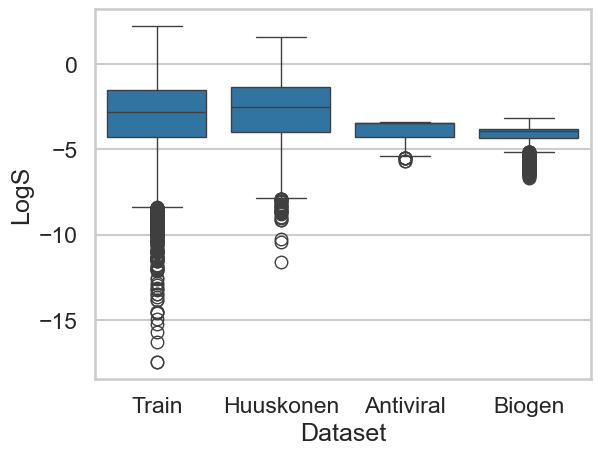

In [18]:
ax = sns.boxplot(data=combo_df, x='dataset', y='LogS')
ax.set_xlabel("Dataset")

Summarize the number of records and IQR of LogS in each dataset.

In [19]:
for k,v in combo_df.groupby('dataset'):
    print(f"{k}: n={len(v)}, LogS IQR={iqr(v.LogS):.2f}")

Antiviral: n=477, LogS IQR=0.83
Biogen: n=2173, LogS IQR=0.55
Huuskonen: n=1282, LogS IQR=2.59
Train: n=17935, LogS IQR=2.75


Evaluate the similarity of each test datasets to the training dataset.

In [20]:
dataset_list = ['Huuskonen', 'Antiviral', 'Biogen']
train_df = combo_df.query("dataset == 'Train'")
df_list = []
for dataset in dataset_list:
    test_df = combo_df.query("dataset == @dataset").copy()
    test_df = find_most_similar(test_df, train_df)
    df_list.append(test_df)
similarity_df = pd.concat(df_list)

Finding most similar: 100%|██████████| 2173/2173 [00:02<00:00, 875.97it/s]


Text(0, 0.5, 'Most Similar Tanimoto')

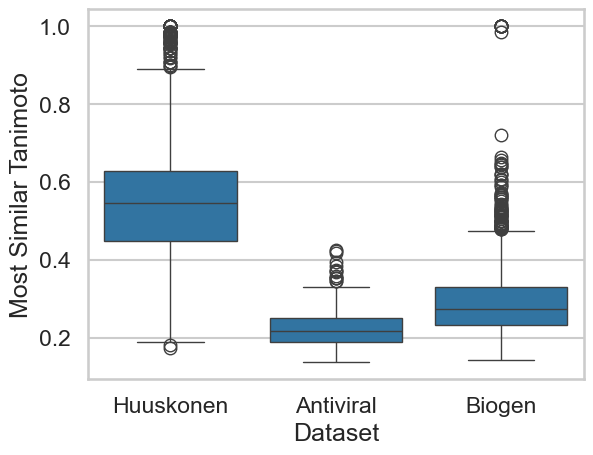

In [21]:
ax = sns.boxplot(x='dataset', y='most_similar', data=similarity_df)
ax.set_xlabel("Dataset")
ax.set_ylabel("Most Similar Tanimoto")

Define a function to train an XGBoost model on the training dataset.

In [22]:
def train_model(df, train_label):
    train_df = df.query("dataset == @train_label")
    X_train = np.stack(train_df['desc'].values)
    y_train = train_df['LogS'].values
    xgb = XGBRegressor(learning_rate =0.01,n_estimators=2000,max_depth=8,min_child_weight=4,gamma=0,subsample=0.7,
                                          colsample_bytree=0.8,nthread=2,scale_pos_weight=1,seed=27)
    xgb.fit(X_train, y_train)
    return xgb

In [23]:
xgb = train_model(combo_df, 'Train')

Define a function to make predictions and evaluate the model on a given dataset.

In [27]:
def predict_and_evaluate(model, df, label):
    df = df.query("dataset == @label")
    X = np.stack(df['desc'].values)
    y_true = df['LogS'].values
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return y_true, y_pred, r2, mae

Evaluate the model on the Huuskonen, Antiviral, and Biogen datasets, and collect the results for plotting.

In [28]:
result_list = []
for label in dataset_list:
    truth, pred, r2, mae = predict_and_evaluate(xgb, combo_df, label)
    print(f"{label}: R2={r2:.3f}, MAE={mae:.3f}")
    result_list.append(pd.DataFrame({
        'True': truth,
        'Predicted': pred,
        'Dataset': label,
        'R2': r2,
        'MAE': mae
    }))
results_df = pd.concat(result_list)

Huuskonen: R2=0.924, MAE=0.414
Antiviral: R2=-3.164, MAE=1.069
Biogen: R2=-1.586, MAE=0.921


Plot the predicted vs true LogS for each dataset.

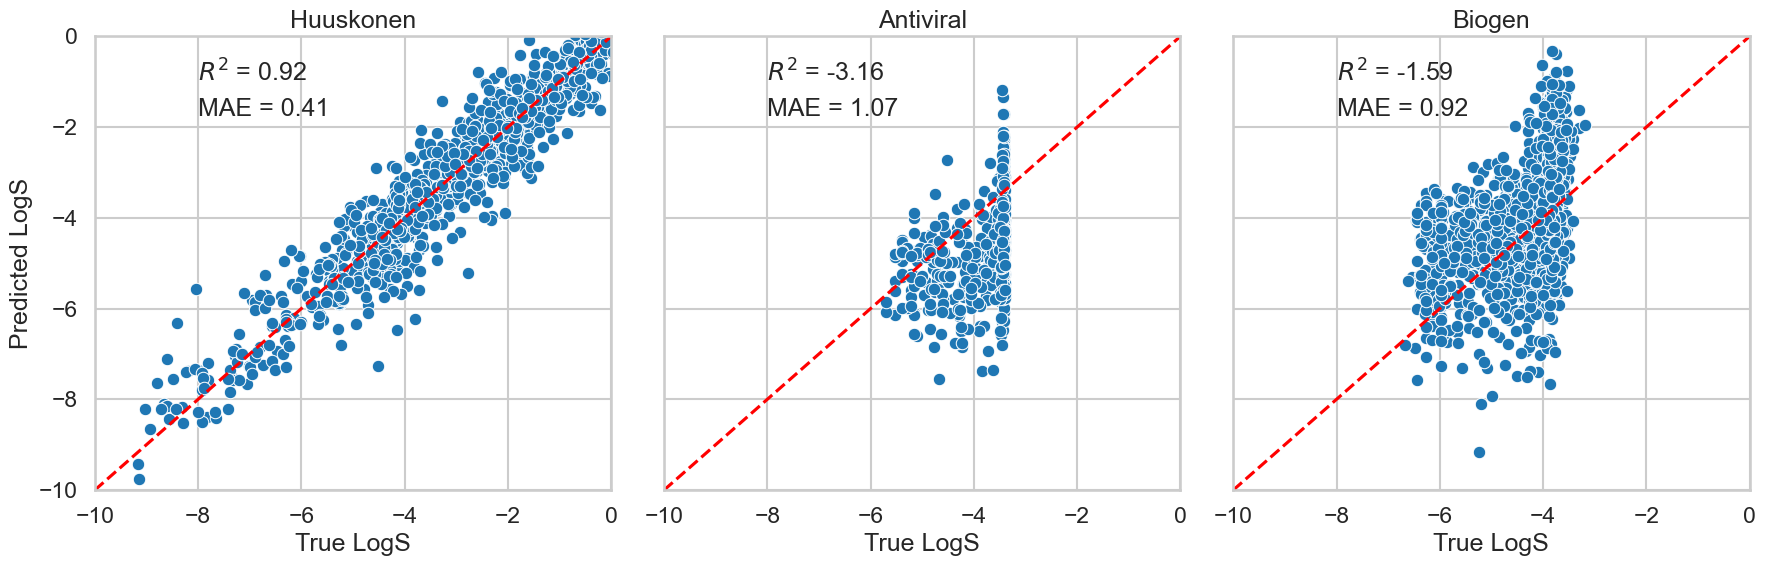

In [29]:
figure, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for ax, label in zip(axes,dataset_list):
    sns.scatterplot(data=results_df.query("Dataset == @label"), x='True', y='Predicted', ax=ax)
    r2, mae = results_df.query("Dataset == @label")[["R2","MAE"]].values[0]
    ax.set_title(label)
    ax.plot([-10, 0], [-10, 0], 'r--')
    ax.set_xlim(-10, 0)
    ax.set_ylim(-10, 0)
    ax.set_xlabel('True LogS')
    ax.set_ylabel('Predicted LogS')
    ax.text(-8,-1,f"$R^2$ = {r2:.2f}")
    ax.text(-8,-1.75,f"MAE = {mae:.2f}")
plt.tight_layout()
plt.show()

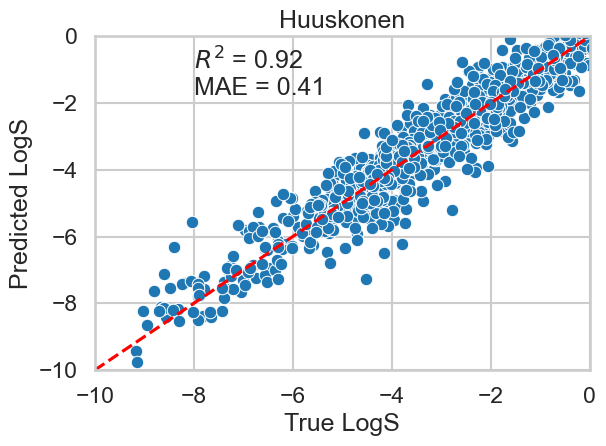

In [30]:
figure, axes = plt.subplots(1,1)
for ax, label in zip([axes],dataset_list):
    sns.scatterplot(data=results_df.query("Dataset == @label"), x='True', y='Predicted', ax=ax)
    r2, mae = results_df.query("Dataset == @label")[["R2","MAE"]].values[0]
    ax.set_title(label)
    ax.plot([-10, 0], [-10, 0], 'r--')
    ax.set_xlim(-10, 0)
    ax.set_ylim(-10, 0)
    ax.set_xlabel('True LogS')
    ax.set_ylabel('Predicted LogS')
    ax.text(-8,-1,f"$R^2$ = {r2:.2f}")
    ax.text(-8,-1.75,f"MAE = {mae:.2f}")
plt.tight_layout()
plt.show()

In [31]:
for k,v in combo_df.groupby("dataset"):
    if k == "Train":
        continue
    mean_val = v.LogS.mean()
    print(k,np.mean(np.abs(v.LogS-mean_val)))

Antiviral 0.5237139651314936
Biogen 0.539388956352846
Huuskonen 1.5949809433875017
